In [8]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
models = ["gemma3:4b", "cogito:3b", "gemma3n:e4b"]
models_split = [model.split(":")[0] for model in models]
model_jsons = [[] for _ in models]

directory_path = "generations\llm_test"

#Add the respective model json outputs to the model_jsons for each model
for entry in os.listdir(directory_path):
    full_path = os.path.join(directory_path, entry)
    if os.path.isfile(full_path):
        for i in range(len(models)):
            if (models_split[i] + "_") in full_path:
                with open(full_path, 'r') as file:
                    data = json.load(file)
                    for item in data:
                        item["shots"] = full_path.split("_")[-1].split(".")[0]
                    model_jsons[i].append(data)
                break

In [12]:
#Check exact match between the aspect sentiments
def strict_match(pred, gold):
    return tuple(pred) == tuple(gold)

#Get percentage of matching aspect sentiments
def partial_match(pred, gold):
    matches = sum(p == g for p, g in zip(pred, gold))
    return matches / len(pred)

#Return a dictionary of the evaluated datapoint
def evaluate_datapoint(item):
    #Get the model output and the ground truth
    preds = item["pred_label"]
    golds = item["tuple_list"]

    #Set strict correct if any of the tuples are exact
    strict_correct = int(any(strict_match(p, g) for p in preds for g in golds))

    #Set partial output to max of the tuples matching
    partial_correct = max((partial_match(p, g) for p in preds for g in golds), default=0)

    return {
        "strict_correct": strict_correct,
        "partial_correct": partial_correct,
        "num_preds": len(preds),
        "num_golds": len(golds)
    }

#Create dataframe for each datapoint
def generate_evaluations(model_jsons):
    rows = []
    for model_name, model_jsons in zip(models, model_jsons):
        for model_json in model_jsons:
            for item in model_json:
                eval_result = evaluate_datapoint(item)
                rows.append({
                    "model": model_name,
                    "shots": item["shots"],
                    "index": item["id"].split("_")[0],
                    "id": item["id"],
                    "text": item["text"],
                    "pred_label": item["pred_label"],
                    "gold_label": item["tuple_list"],
                    "strict_correct": eval_result["strict_correct"],
                    "partial_correct": eval_result["partial_correct"],
                    "num_preds": eval_result["num_preds"],
                    "num_golds": eval_result["num_golds"],
                })

    df = pd.DataFrame(rows)
    return df   

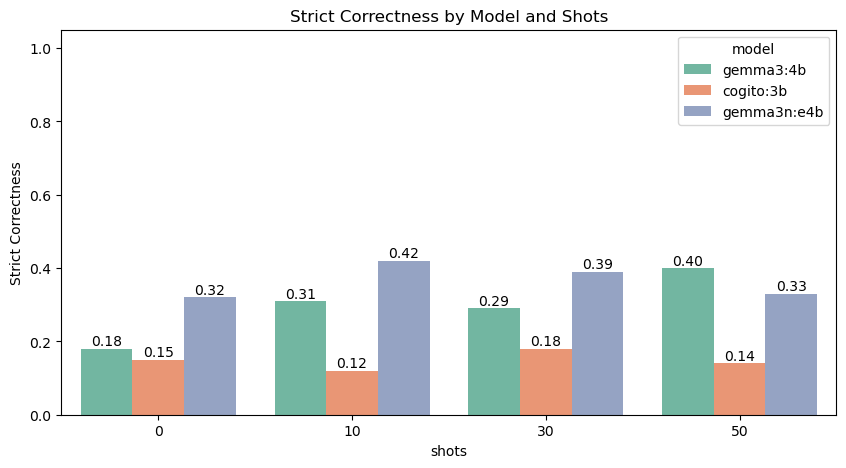

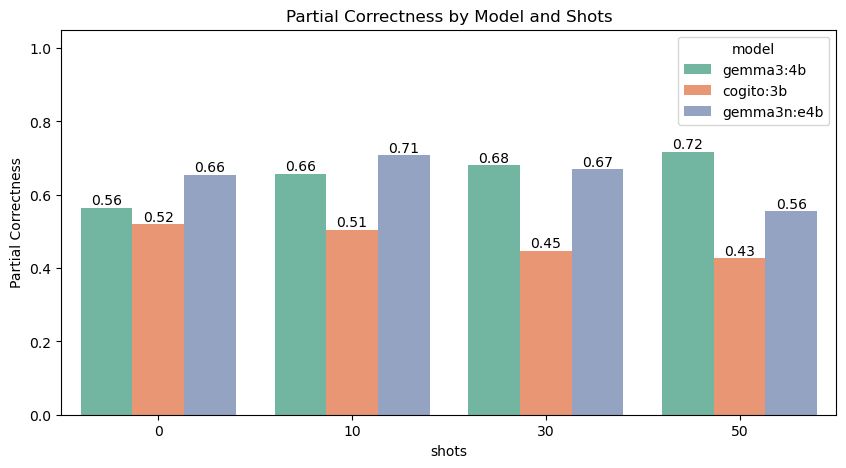

In [13]:
model_evals = generate_evaluations(model_jsons)

# Strict correctness plot
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=model_evals, 
    x='shots', 
    y='strict_correct', 
    hue='model', 
    errorbar=None, 
    palette='Set2'
)
plt.title('Strict Correctness by Model and Shots')
plt.ylabel('Strict Correctness')
plt.ylim(0, 1.05)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.2f}',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=10
        )

# Partial correctness plot
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=model_evals, 
    x='shots', 
    y='partial_correct', 
    hue='model', 
    errorbar=None, 
    palette='Set2'
)

plt.title('Partial Correctness by Model and Shots')
plt.ylabel('Partial Correctness')
plt.ylim(0, 1.05)

for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(
            f'{height:.2f}',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=10
        )
plt.show()